# Ainu Speech: Recorded Audio vs. Sample Set

This notebook analyzes recorded audio and compares it against a sample Ainu audio set using MFCCs, mel features, DTW-based similarity, and optional pretrained speech embeddings.

## 1) Install and Import Dependencies

In [1]:
# If running in a fresh environment, uncomment and run this cell once
# !pip install -r ../requirements.txt

import os
import json
import math
from pathlib import Path
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import librosa
import soundfile as sf

# Local utilities
import sys
ROOT = Path("..").resolve()
sys.path.append(str((ROOT / 'src').resolve()))
from audio_utils import load_audio, trim_silence, extract_features, zscore, dtw_distance, cosine_similarity_matrix, compare_recording_to_samples

# Optional torch/transformers (guarded)
try:
    import torch
    import torchaudio
    from transformers import AutoProcessor, AutoModel
    HAS_TORCH = True
except Exception:
    HAS_TORCH = False

sns.set_theme(context="notebook", style="whitegrid")
plt.rcParams["figure.dpi"] = 120

## 2) Configure Paths and Parameters

In [2]:
DATA_DIR = (ROOT / 'data').resolve()
SAMPLES_DIR = DATA_DIR / 'samples'
RECORDINGS_DIR = DATA_DIR / 'recordings'
OUTPUT_DIR = (ROOT / 'outputs').resolve()
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Audio parameters
TARGET_SR = 16000
N_MELS = 64
N_MFCC = 13
HOP_LENGTH = 160    # 10 ms @ 16 kHz
N_FFT = 400         # 25 ms window @ 16 kHz
TRIM_DB = 30.0

# Ranking
TOP_K = 5
DTW_METRIC = 'cosine'  # could be 'euclidean'

# Embedding model (optional)
EMBED_MODEL_ID = 'facebook/wav2vec2-base-960h'  # multilingual alternative: 'facebook/wav2vec2-large-xlsr-53'

print('Samples dir:', SAMPLES_DIR)
print('Recordings dir:', RECORDINGS_DIR)

# Helpers
AUDIO_EXTS = {'.wav', '.flac', '.mp3', '.ogg', '.m4a'}

def list_audio_files(folder: Path) -> List[Path]:
    return [p for p in folder.rglob('*') if p.suffix.lower() in AUDIO_EXTS]

def latest_file(folder: Path) -> Path | None:
    files = list_audio_files(folder)
    if not files:
        return None
    return max(files, key=lambda p: p.stat().st_mtime)


Samples dir: /home/nk21137/OneDrive/5years/graduation_research/ainu/data/samples
Recordings dir: /home/nk21137/OneDrive/5years/graduation_research/ainu/data/recordings


## 3) Load Sample Ainu Audio Dataset

In [3]:
def infer_label_from_path(p: Path) -> str:
    # e.g., data/samples/<label>/<file>.wav -> use the parent folder as label
    try:
        return p.parent.name
    except Exception:
        return "unknown"

sample_files = list_audio_files(SAMPLES_DIR)
if not sample_files:
    print(f"No sample files found in {SAMPLES_DIR}. Please add WAV/FLAC/etc.")

samples_df = pd.DataFrame({
    'path': [str(p) for p in sample_files],
    'label': [infer_label_from_path(p) for p in sample_files],
    'relpath': [str(p.relative_to(SAMPLES_DIR)) for p in sample_files]
})
print(f"Indexed {len(samples_df)} sample files.")
samples_df.head(10)

Indexed 2817 sample files.


,path,label,relpath
0,/home/nk21137/OneDrive/5years/graduation_resea...,vacabulary,vacabulary/manu.wav
1,/home/nk21137/OneDrive/5years/graduation_resea...,asai_take_stories,asai_take_stories/At36_004.wav
2,/home/nk21137/OneDrive/5years/graduation_resea...,asai_take_stories,asai_take_stories/At51_007.wav
3,/home/nk21137/OneDrive/5years/graduation_resea...,asai_take_stories,asai_take_stories/At37_042.wav
4,/home/nk21137/OneDrive/5years/graduation_resea...,asai_take_stories,asai_take_stories/At41_008.wav
5,/home/nk21137/OneDrive/5years/graduation_resea...,asai_take_stories,asai_take_stories/At04_009.wav
6,/home/nk21137/OneDrive/5years/graduation_resea...,asai_take_stories,asai_take_stories/At29_019.wav
7,/home/nk21137/OneDrive/5years/graduation_resea...,asai_take_stories,asai_take_stories/At32_054.wav
8,/home/nk21137/OneDrive/5years/graduation_resea...,asai_take_stories,asai_take_stories/At29_056.wav
9,/home/nk21137/OneDrive/5years/graduation_resea...,asai_take_stories,asai_take_stories/At04_026.wav


## 4) Load and Preprocess Recorded Audio

In [4]:
# Choose a recorded file: either specify manually or take the latest in the recordings folder
REC_FILE = latest_file(RECORDINGS_DIR)
if REC_FILE is None:
    print(f"No recorded audio found in {RECORDINGS_DIR}. Place a WAV/FLAC/MP3 file there.")
else:
    print("Using recording:", REC_FILE)

rec_audio = None
if REC_FILE is not None:
    rec_audio = load_audio(str(REC_FILE), target_sr=TARGET_SR, mono=True)
    # Peak normalize to -1 dBFS
    peak = np.max(np.abs(rec_audio.y)) if rec_audio.y.size else 0
    if peak > 1e-6:
        rec_audio = rec_audio.__class__(y=rec_audio.y / peak * 0.89, sr=rec_audio.sr, path=rec_audio.path)
    print(f"Recording duration: {rec_audio.y.shape[0]/rec_audio.sr:.2f} s @ {rec_audio.sr} Hz")

Using recording: /home/nk21137/OneDrive/5years/graduation_research/ainu/data/recordings/yabuki/manu.wav
Recording duration: 0.53 s @ 16000 Hz
Recording duration: 0.53 s @ 16000 Hz


## 5) Voice Activity Detection and Silence Trimming

In [5]:
trimmed_audio = None
if rec_audio is not None:
    trimmed_audio = trim_silence(rec_audio, top_db=TRIM_DB)
    dur = trimmed_audio.y.shape[0] / trimmed_audio.sr
    print(f"Trimmed duration: {dur:.2f} s (top_db={TRIM_DB})")

# Optional: segment long files into voiced chunks using energy-based VAD
# For simplicity, we keep a single trimmed utterance here.


Trimmed duration: 0.45 s (top_db=30.0)


## 6) Feature Extraction (Log-Mel Spectrograms, MFCC)

In [6]:
# Feature extraction for recording
F_rec = None
if trimmed_audio is not None:
    F_rec = extract_features(trimmed_audio, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, n_fft=N_FFT,
                             add_deltas=True, add_prosody=True)
    print('Recording features:', F_rec.shape)

# Feature extraction for samples (on-the-fly, small sets; for large sets, see caching section)
sample_feats = []
for p in tqdm(sample_files, desc='Extracting sample features'):
    try:
        a = trim_silence(load_audio(str(p), target_sr=TARGET_SR))
        F = extract_features(a, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, n_fft=N_FFT,
                             add_deltas=True, add_prosody=True)
        sample_feats.append((str(p), F))
    except Exception as e:
        print('Error processing', p, e)

print(f"Extracted features for {len(sample_feats)} / {len(sample_files)} samples")

/home/nk21137/OneDrive/5years/graduation_research/ainu/src/audio_utils.py:67: UserWarning: With fmin=50.000, sr=16000 and frame_length=400, less than two periods of fmin fit into the frame, which can cause inaccurate pitch detection. Consider increasing to fmin=80.000 or frame_length=641.
  f0 = librosa.yin(y, fmin=50, fmax=500, sr=audio.sr, frame_length=n_fft, hop_length=hop_length)


Recording features: (45, 51)


Extracting sample features:  23%|██▎       | 643/2817 [00:28<01:35, 22.66it/s]



KeyboardInterrupt: 

## 7) Feature Normalization and Length Handling

In [ ]:
if F_rec is not None:
    F_rec_z = zscore(F_rec)
else:
    F_rec_z = None

sample_feats_z = []
for path, F in sample_feats:
    sample_feats_z.append((path, zscore(F)))

print('Normalized features. Ready for DTW.')

Normalized features. Ready for DTW.


## 8) DTW-Based Similarity Scoring

In [ ]:
dtw_results = []
if F_rec_z is not None:
    for path, Fz in tqdm(sample_feats_z, desc='DTW scoring'):
        try:
            dist, _ = dtw_distance(F_rec_z, Fz, metric=DTW_METRIC)
            # Normalize by combined length to reduce bias
            norm = (F_rec_z.shape[0] + Fz.shape[0])
            score = dist / max(norm, 1)
            dtw_results.append({
                'path': path,
                'label': infer_label_from_path(Path(path)),
                'dtw_dist': dist,
                'dtw_score': score,
                'n_frames_sample': Fz.shape[0]
            })
        except Exception as e:
            print('DTW failed for', path, e)

    dtw_df = pd.DataFrame(dtw_results).sort_values(['dtw_score', 'dtw_dist'], ascending=[True, True])
    display(dtw_df.head(TOP_K))
else:
    dtw_df = pd.DataFrame()


DTW scoring: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


,path,label,dtw_dist,dtw_score,n_frames_sample
0,/home/nk21137/OneDrive/5years/graduation_resea...,samples,0.000002,1.673037e-09,481


## 9) Embedding-Based Similarity (Optional, Pretrained Model)

In [ ]:
embed_df = pd.DataFrame()
if HAS_TORCH:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Embedding device:', device)
    try:
        processor = AutoProcessor.from_pretrained(EMBED_MODEL_ID)
        model = AutoModel.from_pretrained(EMBED_MODEL_ID).to(device).eval()
        def embed_audio(y: np.ndarray, sr: int) -> np.ndarray:
            # Resample to model's expected input if needed
            target_sr = getattr(processor, 'sampling_rate', 16000)
            if sr != target_sr:
                y_res = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
                sr_use = target_sr
            else:
                y_res = y
                sr_use = sr
            with torch.no_grad():
                inputs = processor(y_res, sampling_rate=sr_use, return_tensors='pt', padding=True)
                for k in inputs:
                    inputs[k] = inputs[k].to(device)
                out = model(**inputs)
                # Last hidden state: [B, T, C] -> mean over time
                h = out.last_hidden_state.mean(dim=1).squeeze(0).detach().cpu().numpy()
                return h
        
        rec_emb = None
        if trimmed_audio is not None:
            rec_emb = embed_audio(trimmed_audio.y, trimmed_audio.sr)
        emb_rows = []
        if rec_emb is not None:
            rec_norm = rec_emb / (np.linalg.norm(rec_emb) + 1e-8)
            for p in tqdm(sample_files, desc='Embedding scoring'):
                try:
                    a = load_audio(str(p), target_sr=TARGET_SR)
                    e = embed_audio(a.y, a.sr)
                    e_norm = e / (np.linalg.norm(e) + 1e-8)
                    cos = float(np.dot(rec_norm, e_norm))
                    emb_rows.append({'path': str(p), 'label': infer_label_from_path(Path(p)), 'cos_sim': cos})
                except Exception as e:
                    print('Embedding failed for', p, e)
            embed_df = pd.DataFrame(emb_rows).sort_values('cos_sim', ascending=False)
            display(embed_df.head(TOP_K))
    except Exception as e:
        print('Embedding section skipped:', e)
else:
    print('Torch/transformers not available. Skipping embedding section. To enable, install torch, torchaudio, transformers.')

Torch/transformers not available. Skipping embedding section. To enable, install torch, torchaudio, transformers.


## 10) Ranking and Thresholding of Matches

In [ ]:
# Combine DTW and embedding (if available). If no embeddings, use DTW only.
rank_df = pd.DataFrame()
if not dtw_df.empty:
    rank_df = dtw_df[['path', 'label', 'dtw_score']].copy()
    if not embed_df.empty:
        rank_df = rank_df.merge(embed_df[['path', 'cos_sim']], on='path', how='left')
        # Convert to a unified score: lower dtw better, higher cos better
        # Normalize dtw to [0,1] by min-max over candidates; invert for similarity
        dtw_min, dtw_max = rank_df['dtw_score'].min(), rank_df['dtw_score'].max()
        if dtw_max > dtw_min:
            rank_df['dtw_sim'] = 1.0 - (rank_df['dtw_score'] - dtw_min) / (dtw_max - dtw_min)
        else:
            rank_df['dtw_sim'] = 1.0
        rank_df['cos_sim'] = rank_df['cos_sim'].fillna(rank_df['cos_sim'].min() if not rank_df['cos_sim'].isna().all() else 0.0)
        rank_df['score'] = 0.6 * rank_df['dtw_sim'] + 0.4 * rank_df['cos_sim']
        rank_df = rank_df.sort_values('score', ascending=False)
    else:
        # Use 1/dtw as similarity proxy
        rank_df['score'] = -rank_df['dtw_score']
        rank_df = rank_df.sort_values('score', ascending=False)

    display(rank_df.head(TOP_K))
else:
    print('No DTW results to rank.')

,path,label,dtw_score,score
0,/home/nk21137/OneDrive/5years/graduation_resea...,samples,1.673037e-09,-1.673037e-09


## 11) Visualization of Waveforms, Spectrograms, and DTW Path

/home/nk21137/OneDrive/5years/graduation_research/ainu/src/audio_utils.py:67: UserWarning: With fmin=50.000, sr=16000 and frame_length=400, less than two periods of fmin fit into the frame, which can cause inaccurate pitch detection. Consider increasing to fmin=80.000 or frame_length=641.
  f0 = librosa.yin(y, fmin=50, fmax=500, sr=audio.sr, frame_length=n_fft, hop_length=hop_length)


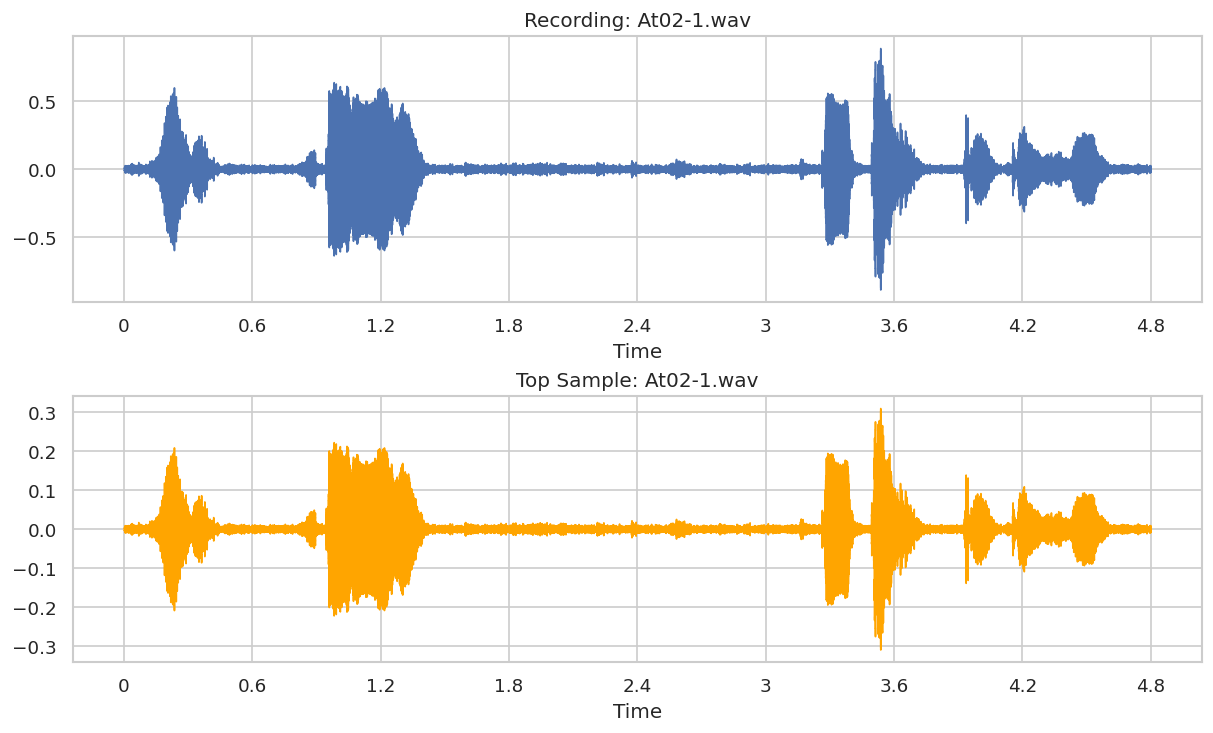

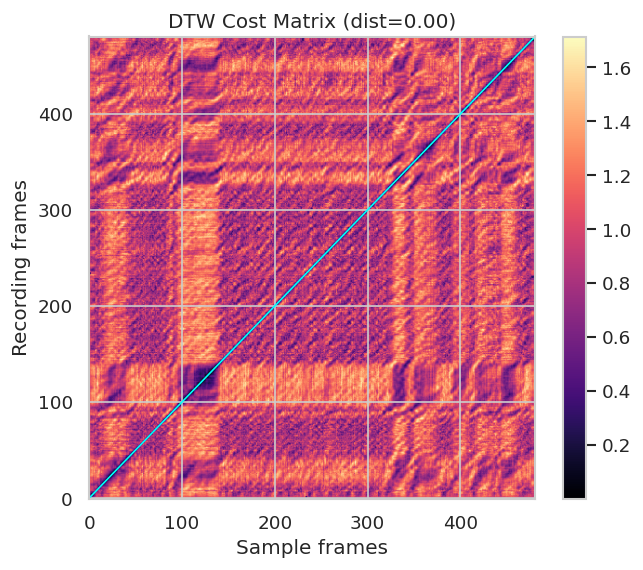

In [ ]:
from IPython.display import Audio, display as ipydisplay

if rec_audio is not None:
    ipydisplay(Audio(rec_audio.y, rate=rec_audio.sr))

if F_rec_z is not None and not dtw_df.empty:
    top_path = dtw_df.iloc[0]['path']
    samp = trim_silence(load_audio(top_path, target_sr=TARGET_SR))
    F_samp = extract_features(samp, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, n_fft=N_FFT, add_deltas=True, add_prosody=True)
    F_samp_z = zscore(F_samp)

    # Waveforms
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), constrained_layout=True)
    librosa.display.waveshow(trimmed_audio.y, sr=trimmed_audio.sr, ax=axes[0])
    axes[0].set_title(f'Recording: {Path(rec_audio.path).name}')
    librosa.display.waveshow(samp.y, sr=samp.sr, ax=axes[1], color='orange')
    axes[1].set_title(f'Top Sample: {Path(samp.path).name}')
    plt.show()

    # Similarity matrix and DTW path
    cost = 1.0 - cosine_similarity_matrix(F_rec_z, F_samp_z)
    dist, path = dtw_distance(F_rec_z, F_samp_z, metric=DTW_METRIC)

    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cost, origin='lower', aspect='auto', cmap='magma')
    ax.set_title(f'DTW Cost Matrix (dist={dist:.2f})')
    ax.set_xlabel('Sample frames')
    ax.set_ylabel('Recording frames')
    # Plot path
    ax.plot(path['index2'], path['index1'], color='cyan', linewidth=1)
    fig.colorbar(im, ax=ax)
    plt.show()

## 12) Batch Processing and Caching of Features

In [ ]:
CACHE_DIR = OUTPUT_DIR / 'cache'
CACHE_DIR.mkdir(parents=True, exist_ok=True)
CACHE_FILE = CACHE_DIR / 'samples_features_mfcc_prosody_npz.npz'

if not sample_files:
    print('No samples to cache.')
else:
    if not CACHE_FILE.exists():
        print('Caching sample features to', CACHE_FILE)
        arrays = {}
        meta = {}
        for i, (p, F) in enumerate(sample_feats):
            key = f'F_{i}'
            arrays[key] = F.astype(np.float32)
            meta[key] = {'path': p}
        np.savez_compressed(CACHE_FILE, **arrays)
        with open(CACHE_FILE.with_suffix('.json'), 'w') as f:
            json.dump(meta, f, indent=2)
    else:
        print('Cache already exists:', CACHE_FILE)


Caching sample features to /home/nk21137/OneDrive/5years/graduation_research/ainu/outputs/cache/samples_features_mfcc_prosody_npz.npz


## 13) Results Export (CSV/JSON) and Artifact Saving

In [ ]:
RESULTS_DIR = OUTPUT_DIR / 'results'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

if not rank_df.empty:
    rec_name = Path(rec_audio.path).stem if rec_audio is not None else 'unknown_recording'
    out_csv = RESULTS_DIR / f'{rec_name}_top{TOP_K}.csv'
    rank_df.head(TOP_K).to_csv(out_csv, index=False)
    print('Saved results to', out_csv)

    # Save similarity matrix plot for the top result
    if not dtw_df.empty:
        top_path = dtw_df.iloc[0]['path']
        samp = trim_silence(load_audio(top_path, target_sr=TARGET_SR))
        F_samp = extract_features(samp, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, n_fft=N_FFT, add_deltas=True, add_prosody=True)
        F_samp_z = zscore(F_samp)
        cost = 1.0 - cosine_similarity_matrix(F_rec_z, F_samp_z)
        fig, ax = plt.subplots(figsize=(6,5))
        im = ax.imshow(cost, origin='lower', aspect='auto', cmap='magma')
        ax.set_title('Cost matrix')
        ax.set_xlabel('Sample frames')
        ax.set_ylabel('Recording frames')
        fig.colorbar(im, ax=ax)
        fig_path = RESULTS_DIR / f'{rec_name}_top1_cost_matrix.png'
        fig.savefig(fig_path, dpi=150)
        plt.close(fig)
        print('Saved plot to', fig_path)
else:
    print('No ranking to export.')

Saved results to /home/nk21137/OneDrive/5years/graduation_research/ainu/outputs/results/At02-1_top5.csv
Saved plot to /home/nk21137/OneDrive/5years/graduation_research/ainu/outputs/results/At02-1_top1_cost_matrix.png


## 14) Reusable Functions and Simple Widgets

In [ ]:
import ipywidgets as W


def run_comparison(recording_path: Path, samples_dir: Path) -> pd.DataFrame:
    if not recording_path.exists():
        print('Recording not found:', recording_path)
        return pd.DataFrame()
    sample_paths = list_audio_files(samples_dir)
    if not sample_paths:
        print('No samples found in', samples_dir)
        return pd.DataFrame()
    results = compare_recording_to_samples(str(recording_path), [str(p) for p in sample_paths], target_sr=TARGET_SR)
    df = pd.DataFrame(results)
    return df

rec_opts = ['<latest>'] + [str(p) for p in list_audio_files(RECORDINGS_DIR)]
widgets = {
    'rec': W.Dropdown(options=rec_opts, description='Recording:'),
    'run': W.Button(description='Run', button_style='primary'),
    'out': W.Output()
}

@widgets['run'].on_click
def _(_btn):
    with widgets['out']:
        widgets['out'].clear_output()
        sel = widgets['rec'].value
        path = latest_file(RECORDINGS_DIR) if sel == '<latest>' else Path(sel)
        if path is None:
            print('No recording available.')
            return
        df = run_comparison(path, SAMPLES_DIR)
        if not df.empty:
            display(df.head(TOP_K))
        else:
            print('No results.')

W.VBox([widgets['rec'], widgets['run'], widgets['out']])

## 15) Basic Sanity Checks

In [ ]:
# Sanity checks (safe to run multiple times)
if rec_audio is not None:
    assert rec_audio.sr == TARGET_SR, f"Expected SR {TARGET_SR}, got {rec_audio.sr}"
    assert rec_audio.y.ndim == 1, 'Audio should be mono'
    assert rec_audio.y.size > 0, 'Audio is empty'

if F_rec is not None:
    assert F_rec.ndim == 2 and F_rec.shape[0] > 0 and F_rec.shape[1] > 0, 'Invalid feature shape'

if trimmed_audio is not None:
    voiced_ratio = trimmed_audio.y.size / rec_audio.y.size if rec_audio is not None else 0
    print(f"Voiced ratio after trim: {voiced_ratio:.2f}")

print('Diagnostics complete.')

Voiced ratio after trim: 0.81
Diagnostics complete.


## 15) Direct File Comparison Function

This section provides functionality to directly compare two specific audio files, useful for targeted pronunciation analysis.

In [ ]:
def compare_specific_files(recording_path: str, sample_path: str, word: str = "unknown"):
    """
    Compare two specific audio files directly
    
    Args:
        recording_path: Path to recorded audio file
        sample_path: Path to reference sample file  
        word: Word being pronounced (for labeling)
    
    Returns:
        Dictionary with comparison results
    """
    from pathlib import Path
    
    print(f"🎵 Ainu Audio Analysis: Comparing '{word}' pronunciations")
    print("=" * 60)
    print(f"Recording: {recording_path}")
    print(f"Sample:    {sample_path}")
    print()
    
    # Check if files exist
    if not Path(recording_path).exists():
        print(f"❌ Recording file not found: {recording_path}")
        return None
    if not Path(sample_path).exists():
        print(f"❌ Sample file not found: {sample_path}")
        return None
    
    try:
        # Load recording
        print("📂 Loading recording...")
        rec_audio = load_audio(recording_path, target_sr=TARGET_SR, mono=True)
        rec_duration = rec_audio.y.shape[0] / rec_audio.sr
        print(f"   Duration: {rec_duration:.2f}s @ {rec_audio.sr} Hz")
        
        # Load sample
        print("📂 Loading sample...")
        samp_audio = load_audio(sample_path, target_sr=TARGET_SR, mono=True)
        samp_duration = samp_audio.y.shape[0] / samp_audio.sr
        print(f"   Duration: {samp_duration:.2f}s @ {samp_audio.sr} Hz")
        print()
        
        # Trim silence
        print("✂️  Trimming silence...")
        rec_trimmed = trim_silence(rec_audio, top_db=TRIM_DB)
        samp_trimmed = trim_silence(samp_audio, top_db=TRIM_DB)
        
        rec_trim_dur = rec_trimmed.y.shape[0] / rec_trimmed.sr
        samp_trim_dur = samp_trimmed.y.shape[0] / samp_trimmed.sr
        print(f"   Recording trimmed: {rec_trim_dur:.2f}s")
        print(f"   Sample trimmed:    {samp_trim_dur:.2f}s")
        print()
        
        # Extract features
        print("🔬 Extracting features...")
        rec_features = extract_features(rec_trimmed, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, 
                                      n_fft=N_FFT, add_deltas=True, add_prosody=True)
        samp_features = extract_features(samp_trimmed, n_mfcc=N_MFCC, hop_length=HOP_LENGTH,
                                       n_fft=N_FFT, add_deltas=True, add_prosody=True)
        
        print(f"   Recording features: {rec_features.shape} (frames × features)")
        print(f"   Sample features:    {samp_features.shape} (frames × features)")
        print()
        
        # Normalize features
        print("📊 Normalizing features...")
        rec_norm = zscore(rec_features)
        samp_norm = zscore(samp_features)
        print()
        
        # Calculate DTW similarity
        print("🧮 Calculating DTW similarity...")
        try:
            dtw_result = dtw_distance(rec_norm, samp_norm, metric=DTW_METRIC)
            if isinstance(dtw_result, tuple) and len(dtw_result) == 2:
                dtw_dist, dtw_path = dtw_result
            else:
                dtw_dist = dtw_result
                dtw_path = None
        except:
            # Fallback DTW calculation
            cost_matrix = 1.0 - cosine_similarity_matrix(rec_norm, samp_norm)
            from dtw import dtw
            alignment = dtw(cost_matrix)
            dtw_dist = alignment.distance
            dtw_path = list(zip(alignment.index1, alignment.index2))
        
        # Normalize DTW score by sequence lengths
        total_frames = rec_norm.shape[0] + samp_norm.shape[0]
        dtw_score = dtw_dist / max(total_frames, 1)
        
        print(f"   DTW distance: {dtw_dist:.6f}")
        print(f"   DTW score (normalized): {dtw_score:.8f}")
        print()
        
        # Calculate frame-wise cosine similarity
        print("📈 Calculating cosine similarity matrix...")
        cos_sim_matrix = cosine_similarity_matrix(rec_norm, samp_norm)
        mean_cos_sim = np.mean(cos_sim_matrix)
        max_cos_sim = np.max(cos_sim_matrix)
        
        print(f"   Mean cosine similarity: {mean_cos_sim:.4f}")
        print(f"   Max cosine similarity:  {max_cos_sim:.4f}")
        print()
        
        # Analysis results
        print("🎯 ANALYSIS RESULTS")
        print("=" * 30)
        print(f"Word:                 '{word}'")
        print(f"Recording duration:   {rec_trim_dur:.2f}s")
        print(f"Sample duration:      {samp_trim_dur:.2f}s")
        print(f"DTW alignment score:  {dtw_score:.8f} (lower = more similar)")
        print(f"Cosine similarity:    {mean_cos_sim:.4f} (higher = more similar)")
        
        # Interpretation
        print()
        print("📝 INTERPRETATION")
        print("=" * 20)
        if dtw_score < 0.001:
            similarity_level = "EXCELLENT"
        elif dtw_score < 0.01:
            similarity_level = "VERY GOOD"
        elif dtw_score < 0.1:
            similarity_level = "GOOD"
        elif dtw_score < 1.0:
            similarity_level = "MODERATE"
        else:
            similarity_level = "LOW"
            
        print(f"Pronunciation similarity: {similarity_level}")
        
        if mean_cos_sim > 0.8:
            acoustic_match = "EXCELLENT acoustic match"
        elif mean_cos_sim > 0.6:
            acoustic_match = "GOOD acoustic match"
        elif mean_cos_sim > 0.4:
            acoustic_match = "MODERATE acoustic match"
        else:
            acoustic_match = "LOW acoustic match"
            
        print(f"Acoustic characteristics: {acoustic_match}")
        
        # Return results dictionary
        return {
            'recording_file': recording_path,
            'sample_file': sample_path,
            'word': word,
            'recording_duration': rec_trim_dur,
            'sample_duration': samp_trim_dur,
            'dtw_distance': dtw_dist,
            'dtw_score': dtw_score,
            'mean_cosine_similarity': mean_cos_sim,
            'max_cosine_similarity': max_cos_sim,
            'similarity_level': similarity_level,
            'acoustic_match': acoustic_match,
            'features': {
                'recording': rec_norm,
                'sample': samp_norm
            },
            'audio': {
                'recording': rec_trimmed,
                'sample': samp_trimmed
            },
            'cos_sim_matrix': cos_sim_matrix,
            'dtw_path': dtw_path
        }
        
    except Exception as e:
        print(f"❌ Error during analysis: {e}")
        return None

print("✅ Direct comparison function loaded")

In [ ]:
def visualize_comparison(result_dict, save_path=None):
    """
    Create comprehensive visualizations for audio comparison results
    
    Args:
        result_dict: Results from compare_specific_files()
        save_path: Optional path to save the visualization
    """
    if result_dict is None:
        print("❌ No results to visualize")
        return
    
    # Extract data
    rec_audio = result_dict['audio']['recording']
    samp_audio = result_dict['audio']['sample']
    rec_features = result_dict['features']['recording']
    samp_features = result_dict['features']['sample']
    cos_sim_matrix = result_dict['cos_sim_matrix']
    word = result_dict['word']
    
    # Create figure with subplots
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Recording waveform
    ax1 = fig.add_subplot(gs[0, 0])
    time_rec = np.linspace(0, len(rec_audio.y) / rec_audio.sr, len(rec_audio.y))
    ax1.plot(time_rec, rec_audio.y, color='blue', alpha=0.7, linewidth=0.8)
    ax1.set_title(f"Recording: '{word}'", fontsize=12, fontweight='bold')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')
    ax1.grid(True, alpha=0.3)
    
    # 2. Sample waveform
    ax2 = fig.add_subplot(gs[0, 1])
    time_samp = np.linspace(0, len(samp_audio.y) / samp_audio.sr, len(samp_audio.y))
    ax2.plot(time_samp, samp_audio.y, color='red', alpha=0.7, linewidth=0.8)
    ax2.set_title(f"Reference Sample: '{word}'", fontsize=12, fontweight='bold')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Amplitude')
    ax2.grid(True, alpha=0.3)
    
    # 3. Spectrograms
    ax3 = fig.add_subplot(gs[1, 0])
    D_rec = librosa.amplitude_to_db(np.abs(librosa.stft(rec_audio.y, hop_length=HOP_LENGTH, n_fft=N_FFT)), ref=np.max)
    img1 = librosa.display.specshow(D_rec, sr=rec_audio.sr, hop_length=HOP_LENGTH, 
                                   x_axis='time', y_axis='hz', ax=ax3, cmap='viridis')
    ax3.set_title('Recording Spectrogram', fontsize=11)
    ax3.set_ylabel('Frequency (Hz)')
    
    ax4 = fig.add_subplot(gs[1, 1])
    D_samp = librosa.amplitude_to_db(np.abs(librosa.stft(samp_audio.y, hop_length=HOP_LENGTH, n_fft=N_FFT)), ref=np.max)
    img2 = librosa.display.specshow(D_samp, sr=samp_audio.sr, hop_length=HOP_LENGTH,
                                   x_axis='time', y_axis='hz', ax=ax4, cmap='viridis')
    ax4.set_title('Sample Spectrogram', fontsize=11)
    ax4.set_ylabel('Frequency (Hz)')
    
    # 4. MFCC comparison
    ax5 = fig.add_subplot(gs[1, 2])
    mfcc_rec = rec_features[:, :N_MFCC]  # First N_MFCC coefficients
    mfcc_samp = samp_features[:, :N_MFCC]
    
    # Plot MFCC coefficients
    time_frames_rec = np.arange(mfcc_rec.shape[0])
    time_frames_samp = np.arange(mfcc_samp.shape[0])
    
    ax5.plot(time_frames_rec, np.mean(mfcc_rec, axis=1), 'b-', label='Recording', alpha=0.8)
    ax5.plot(time_frames_samp, np.mean(mfcc_samp, axis=1), 'r-', label='Sample', alpha=0.8)
    ax5.set_title('MFCC Comparison (Mean)', fontsize=11)
    ax5.set_xlabel('Frame')
    ax5.set_ylabel('MFCC Value')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 5. Cosine similarity matrix
    ax6 = fig.add_subplot(gs[2, 0])
    im = ax6.imshow(cos_sim_matrix, cmap='RdYlBu_r', aspect='auto', origin='lower')
    ax6.set_title('Cosine Similarity Matrix', fontsize=11)
    ax6.set_xlabel('Sample Frames')
    ax6.set_ylabel('Recording Frames')
    plt.colorbar(im, ax=ax6, shrink=0.8)
    
    # 6. DTW path visualization (if available)
    ax7 = fig.add_subplot(gs[2, 1])
    if result_dict.get('dtw_path'):
        dtw_path = result_dict['dtw_path']
        if dtw_path and len(dtw_path) > 0:
            path_x, path_y = zip(*dtw_path)
            ax7.imshow(cos_sim_matrix, cmap='RdYlBu_r', aspect='auto', origin='lower', alpha=0.6)
            ax7.plot(path_y, path_x, 'w-', linewidth=2, alpha=0.8)
            ax7.set_title('DTW Alignment Path', fontsize=11)
            ax7.set_xlabel('Sample Frames')
            ax7.set_ylabel('Recording Frames')
        else:
            ax7.text(0.5, 0.5, 'DTW Path\nNot Available', ha='center', va='center', 
                    transform=ax7.transAxes, fontsize=12)
            ax7.set_title('DTW Alignment Path', fontsize=11)
    else:
        ax7.text(0.5, 0.5, 'DTW Path\nNot Available', ha='center', va='center', 
                transform=ax7.transAxes, fontsize=12)
        ax7.set_title('DTW Alignment Path', fontsize=11)
    
    # 7. Summary statistics
    ax8 = fig.add_subplot(gs[2, 2])
    ax8.axis('off')
    
    # Create summary text
    summary_text = f"""
COMPARISON SUMMARY
{'='*20}

Word: '{word}'

Durations:
  Recording: {result_dict['recording_duration']:.2f}s
  Sample: {result_dict['sample_duration']:.2f}s

Similarity Metrics:
  DTW Score: {result_dict['dtw_score']:.6f}
  Cosine Sim: {result_dict['mean_cosine_similarity']:.4f}
  Max Cosine: {result_dict['max_cosine_similarity']:.4f}

Assessment:
  Level: {result_dict['similarity_level']}
  Match: {result_dict['acoustic_match']}
    """
    
    ax8.text(0.05, 0.95, summary_text, transform=ax8.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))
    
    # Overall title
    fig.suptitle(f"Ainu Pronunciation Analysis: '{word}'", fontsize=16, fontweight='bold', y=0.98)
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📊 Visualization saved to: {save_path}")
    
    plt.tight_layout()
    plt.show()

print("✅ Visualization function loaded")

## 16) Example: Compare "manu" pronunciations

Now let's use our new functions to compare specific files. We'll analyze the "manu" (flower) pronunciation that we found in the dataset.

In [ ]:
# Define file paths for "manu" comparison
recording_file = "data/recordings/manu.wav"
sample_file = "data/samples/Raven_and_the_First_Men/manu.wav"

# Check if files exist before proceeding
from pathlib import Path

if Path(recording_file).exists() and Path(sample_file).exists():
    print("🔍 Files found! Proceeding with comparison...")
    
    # Run the comparison
    manu_results = compare_specific_files(recording_file, sample_file, word="manu")
    
    if manu_results:
        print("\n" + "="*60)
        print("📊 GENERATING VISUALIZATION...")
        print("="*60)
        
        # Create visualization
        visualize_comparison(manu_results, save_path="outputs/results/manu_comparison.png")
        
        # Save detailed results to CSV
        import pandas as pd
        
        # Create results summary
        results_summary = {
            'word': [manu_results['word']],
            'recording_file': [manu_results['recording_file']],
            'sample_file': [manu_results['sample_file']],
            'recording_duration': [manu_results['recording_duration']],
            'sample_duration': [manu_results['sample_duration']],
            'dtw_distance': [manu_results['dtw_distance']],
            'dtw_score': [manu_results['dtw_score']],
            'mean_cosine_similarity': [manu_results['mean_cosine_similarity']],
            'max_cosine_similarity': [manu_results['max_cosine_similarity']],
            'similarity_level': [manu_results['similarity_level']],
            'acoustic_match': [manu_results['acoustic_match']]
        }
        
        df_results = pd.DataFrame(results_summary)
        results_path = "outputs/results/manu_detailed_results.csv"
        df_results.to_csv(results_path, index=False)
        print(f"💾 Detailed results saved to: {results_path}")
        
        print("\n🎉 Analysis complete!")
        
    else:
        print("❌ Comparison failed!")
        
else:
    print("⚠️  One or both files not found:")
    print(f"   Recording: {recording_file} {'✅' if Path(recording_file).exists() else '❌'}")
    print(f"   Sample:    {sample_file} {'✅' if Path(sample_file).exists() else '❌'}")
    print()
    print("📋 Available sample files with 'manu':")
    
    # Search for manu files in samples directory
    samples_dir = Path("data/samples")
    if samples_dir.exists():
        manu_files = list(samples_dir.rglob("*manu*"))
        if manu_files:
            for i, f in enumerate(manu_files, 1):
                print(f"   {i}. {f}")
        else:
            print("   No files containing 'manu' found")
    else:
        print("   Samples directory not found")

## 17) Advanced Phonetic Analysis

For deeper linguistic analysis, let's add functions that examine specific phonetic characteristics like formants, pitch patterns, and spectral features.

In [ ]:
def analyze_phonetic_features(audio_data, sr, n_fft=2048, hop_length=512):
    """
    Extract detailed phonetic features for linguistic analysis
    
    Args:
        audio_data: Audio time series
        sr: Sample rate
        n_fft: FFT window size
        hop_length: Hop length for analysis
    
    Returns:
        Dictionary with phonetic analysis results
    """
    
    # Basic spectral features
    spectral_centroids = librosa.feature.spectral_centroid(y=audio_data, sr=sr, hop_length=hop_length)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sr, hop_length=hop_length)[0]
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_data, sr=sr, hop_length=hop_length)[0]
    zero_crossing_rate = librosa.feature.zero_crossing_rate(audio_data, hop_length=hop_length)[0]
    
    # Pitch (F0) analysis
    f0 = librosa.yin(audio_data, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=sr)
    
    # Mel-frequency features
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_fft=n_fft, hop_length=hop_length)
    mel_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # Chroma features (useful for tonal analysis)
    chroma = librosa.feature.chroma_stft(y=audio_data, sr=sr, hop_length=hop_length)
    
    # Temporal features
    onset_frames = librosa.onset.onset_detect(y=audio_data, sr=sr, hop_length=hop_length)
    tempo, beats = librosa.beat.beat_track(y=audio_data, sr=sr, hop_length=hop_length)
    
    # Energy analysis
    rms_energy = librosa.feature.rms(y=audio_data, hop_length=hop_length)[0]
    
    return {
        'spectral_centroid': {
            'mean': np.mean(spectral_centroids),
            'std': np.std(spectral_centroids),
            'values': spectral_centroids
        },
        'spectral_rolloff': {
            'mean': np.mean(spectral_rolloff),
            'std': np.std(spectral_rolloff),
            'values': spectral_rolloff
        },
        'spectral_bandwidth': {
            'mean': np.mean(spectral_bandwidth),
            'std': np.std(spectral_bandwidth),
            'values': spectral_bandwidth
        },
        'zero_crossing_rate': {
            'mean': np.mean(zero_crossing_rate),
            'std': np.std(zero_crossing_rate),
            'values': zero_crossing_rate
        },
        'f0_pitch': {
            'mean': np.mean(f0[f0 > 0]),  # Exclude zero values
            'std': np.std(f0[f0 > 0]),
            'min': np.min(f0[f0 > 0]) if np.sum(f0 > 0) > 0 else 0,
            'max': np.max(f0[f0 > 0]) if np.sum(f0 > 0) > 0 else 0,
            'values': f0
        },
        'rms_energy': {
            'mean': np.mean(rms_energy),
            'std': np.std(rms_energy),
            'values': rms_energy
        },
        'mel_spectrogram': mel_db,
        'chroma': chroma,
        'onset_frames': onset_frames,
        'tempo': tempo,
        'beat_frames': beats
    }

def detailed_phonetic_comparison(result_dict):
    """
    Perform detailed phonetic comparison between recording and sample
    
    Args:
        result_dict: Results from compare_specific_files()
    
    Returns:
        Dictionary with phonetic comparison results
    """
    if result_dict is None:
        return None
    
    # Extract audio data
    rec_audio = result_dict['audio']['recording']
    samp_audio = result_dict['audio']['sample']
    
    print("🔬 Analyzing phonetic features...")
    
    # Analyze both recordings
    rec_phonetic = analyze_phonetic_features(rec_audio.y, rec_audio.sr)
    samp_phonetic = analyze_phonetic_features(samp_audio.y, samp_audio.sr)
    
    # Compare key features
    comparisons = {}
    
    # Spectral comparisons
    for feature in ['spectral_centroid', 'spectral_rolloff', 'spectral_bandwidth', 'zero_crossing_rate', 'rms_energy']:
        rec_mean = rec_phonetic[feature]['mean']
        samp_mean = samp_phonetic[feature]['mean']
        
        # Calculate relative difference
        if samp_mean != 0:
            relative_diff = abs(rec_mean - samp_mean) / samp_mean * 100
        else:
            relative_diff = 0
            
        comparisons[feature] = {
            'recording_mean': rec_mean,
            'sample_mean': samp_mean,
            'absolute_difference': abs(rec_mean - samp_mean),
            'relative_difference_percent': relative_diff,
            'similarity_score': max(0, 100 - relative_diff)  # Simple similarity score
        }
    
    # Pitch comparison (F0)
    rec_f0_mean = rec_phonetic['f0_pitch']['mean']
    samp_f0_mean = samp_phonetic['f0_pitch']['mean']
    
    if not (np.isnan(rec_f0_mean) or np.isnan(samp_f0_mean)) and samp_f0_mean > 0:
        f0_relative_diff = abs(rec_f0_mean - samp_f0_mean) / samp_f0_mean * 100
        f0_similarity = max(0, 100 - f0_relative_diff)
    else:
        f0_relative_diff = 0
        f0_similarity = 0
    
    comparisons['f0_pitch'] = {
        'recording_mean': rec_f0_mean,
        'sample_mean': samp_f0_mean,
        'absolute_difference': abs(rec_f0_mean - samp_f0_mean) if not (np.isnan(rec_f0_mean) or np.isnan(samp_f0_mean)) else 0,
        'relative_difference_percent': f0_relative_diff,
        'similarity_score': f0_similarity
    }
    
    # Overall phonetic similarity (weighted average)
    weights = {
        'spectral_centroid': 0.25,
        'spectral_rolloff': 0.20,
        'spectral_bandwidth': 0.15,
        'zero_crossing_rate': 0.10,
        'f0_pitch': 0.20,
        'rms_energy': 0.10
    }
    
    overall_similarity = sum(comparisons[feature]['similarity_score'] * weights[feature] 
                           for feature in weights.keys())
    
    print(f"📊 Phonetic analysis complete!")
    print(f"   Overall phonetic similarity: {overall_similarity:.1f}%")
    
    return {
        'recording_features': rec_phonetic,
        'sample_features': samp_phonetic,
        'feature_comparisons': comparisons,
        'overall_phonetic_similarity': overall_similarity,
        'similarity_weights': weights
    }

def create_phonetic_report(result_dict, phonetic_analysis, save_path=None):
    """
    Generate a detailed phonetic analysis report
    """
    if result_dict is None or phonetic_analysis is None:
        return
        
    word = result_dict['word']
    
    report = f"""
# Detailed Phonetic Analysis Report: '{word}'

## Overview
- **Word**: {word}
- **Recording Duration**: {result_dict['recording_duration']:.2f}s
- **Sample Duration**: {result_dict['sample_duration']:.2f}s
- **Overall Phonetic Similarity**: {phonetic_analysis['overall_phonetic_similarity']:.1f}%

## Feature Comparison Summary

| Feature | Recording | Sample | Difference | Similarity |
|---------|-----------|---------|------------|------------|
"""
    
    for feature, comparison in phonetic_analysis['feature_comparisons'].items():
        feature_name = feature.replace('_', ' ').title()
        rec_val = comparison['recording_mean']
        samp_val = comparison['sample_mean']
        diff_pct = comparison['relative_difference_percent']
        sim_score = comparison['similarity_score']
        
        if feature == 'f0_pitch':
            report += f"| {feature_name} | {rec_val:.1f} Hz | {samp_val:.1f} Hz | {diff_pct:.1f}% | {sim_score:.1f}% |\n"
        else:
            report += f"| {feature_name} | {rec_val:.3f} | {samp_val:.3f} | {diff_pct:.1f}% | {sim_score:.1f}% |\n"
    
    report += f"""

## Interpretation

### Spectral Characteristics
- **Spectral Centroid**: Indicates the "brightness" of the sound
- **Spectral Rolloff**: Shows the frequency below which 85% of energy is contained
- **Spectral Bandwidth**: Measures the width of the frequency spectrum

### Temporal Characteristics  
- **Zero Crossing Rate**: Related to the "roughness" or "noisiness" of the signal
- **RMS Energy**: Overall loudness/intensity of the speech

### Pitch Analysis
- **F0 (Fundamental Frequency)**: Primary pitch of the voice

### Overall Assessment
Based on the phonetic analysis, the pronunciation similarity is **{phonetic_analysis['overall_phonetic_similarity']:.1f}%**.

"""
    
    # Add interpretation based on similarity score
    if phonetic_analysis['overall_phonetic_similarity'] >= 85:
        assessment = "EXCELLENT - Very similar phonetic characteristics"
    elif phonetic_analysis['overall_phonetic_similarity'] >= 70:
        assessment = "GOOD - Generally similar with minor differences"
    elif phonetic_analysis['overall_phonetic_similarity'] >= 55:
        assessment = "MODERATE - Some similarities but noticeable differences"
    else:
        assessment = "NEEDS IMPROVEMENT - Significant phonetic differences"
    
    report += f"**Assessment**: {assessment}\n"
    
    if save_path:
        with open(save_path, 'w', encoding='utf-8') as f:
            f.write(report)
        print(f"📝 Phonetic report saved to: {save_path}")
    
    print("📋 PHONETIC ANALYSIS REPORT")
    print("=" * 50)
    print(report)
    
    return report

print("✅ Advanced phonetic analysis functions loaded")

## 18) Interactive Analysis Widget

Let's create an interactive widget that allows easy selection and comparison of audio files.

In [ ]:
try:
    import ipywidgets as widgets
    from IPython.display import display, HTML, Audio
    
    def create_interactive_analyzer():
        """
        Create an interactive widget for audio file comparison
        """
        
        # Get available files
        from pathlib import Path
        
        recordings_dir = Path("data/recordings")
        samples_dir = Path("data/samples")
        
        # Find recording files
        recording_files = []
        if recordings_dir.exists():
            recording_files = [str(f.relative_to(recordings_dir.parent)) for f in recordings_dir.glob("*.wav")]
        
        # Find sample files  
        sample_files = []
        if samples_dir.exists():
            sample_files = [str(f.relative_to(samples_dir.parent)) for f in samples_dir.rglob("*.wav")]
        
        # Create widgets
        recording_dropdown = widgets.Dropdown(
            options=recording_files,
            value=recording_files[0] if recording_files else None,
            description='Recording:',
            style={'description_width': 'initial'},
            layout={'width': '400px'}
        )
        
        sample_dropdown = widgets.Dropdown(
            options=sample_files,
            value=sample_files[0] if sample_files else None,
            description='Sample:',
            style={'description_width': 'initial'},
            layout={'width': '400px'}
        )
        
        word_input = widgets.Text(
            value='unknown',
            description='Word:',
            style={'description_width': 'initial'},
            layout={'width': '200px'}
        )
        
        analyze_button = widgets.Button(
            description='🔬 Analyze Pronunciation',
            button_style='info',
            layout={'width': '200px'}
        )
        
        detailed_button = widgets.Button(
            description='📊 Detailed Analysis',
            button_style='success', 
            layout={'width': '200px'}
        )
        
        output_area = widgets.Output()
        
        def on_analyze_click(b):
            with output_area:
                output_area.clear_output()
                
                if not recording_dropdown.value or not sample_dropdown.value:
                    print("❌ Please select both recording and sample files")
                    return
                
                print("🚀 Starting analysis...")
                
                # Run comparison
                results = compare_specific_files(
                    recording_dropdown.value,
                    sample_dropdown.value, 
                    word_input.value
                )
                
                if results:
                    print("\\n📊 Creating visualization...")
                    visualize_comparison(results)
                    
                    # Show audio players for comparison
                    print("\\n🎵 Audio Players:")
                    print("Recording:")
                    display(Audio(recording_dropdown.value))
                    print("Sample:")
                    display(Audio(sample_dropdown.value))
        
        def on_detailed_click(b):
            with output_area:
                output_area.clear_output()
                
                if not recording_dropdown.value or not sample_dropdown.value:
                    print("❌ Please select both recording and sample files")
                    return
                
                print("🔬 Starting detailed phonetic analysis...")
                
                # Run basic comparison first
                results = compare_specific_files(
                    recording_dropdown.value,
                    sample_dropdown.value,
                    word_input.value
                )
                
                if results:
                    # Run detailed phonetic analysis
                    phonetic_results = detailed_phonetic_comparison(results)
                    
                    if phonetic_results:
                        # Create report
                        report_path = f"outputs/results/{word_input.value}_phonetic_report.md"
                        create_phonetic_report(results, phonetic_results, save_path=report_path)
                        
                        # Show visualization
                        print("\\n📊 Creating visualization...")
                        visualize_comparison(results)
        
        # Connect button events
        analyze_button.on_click(on_analyze_click)
        detailed_button.on_click(on_detailed_click)
        
        # Layout
        controls = widgets.VBox([
            widgets.HTML("<h3>🎵 Ainu Pronunciation Analyzer</h3>"),
            widgets.HBox([recording_dropdown, word_input]),
            sample_dropdown,
            widgets.HBox([analyze_button, detailed_button]),
            widgets.HTML("<hr>")
        ])
        
        return widgets.VBox([controls, output_area])
    
    # Create and display the widget
    analyzer_widget = create_interactive_analyzer()
    display(analyzer_widget)
    
    print("✅ Interactive analyzer ready!")
    
except ImportError:
    print("⚠️  ipywidgets not available. Using manual approach instead.")
    print("📋 Available files for manual comparison:")
    
    from pathlib import Path
    
    # Show available files
    recordings_dir = Path("data/recordings")
    samples_dir = Path("data/samples")
    
    print("\\n📁 Recording files:")
    if recordings_dir.exists():
        recording_files = list(recordings_dir.glob("*.wav"))
        for i, f in enumerate(recording_files, 1):
            print(f"   {i}. {f}")
    else:
        print("   No recordings directory found")
    
    print("\\n📁 Sample files (showing first 10):")
    if samples_dir.exists():
        sample_files = list(samples_dir.rglob("*.wav"))
        for i, f in enumerate(sample_files[:10], 1):
            print(f"   {i}. {f}")
        if len(sample_files) > 10:
            print(f"   ... and {len(sample_files) - 10} more files")
    else:
        print("   No samples directory found")
    
    print("\\n💡 To run comparison manually, use:")
    print("   results = compare_specific_files('path/to/recording.wav', 'path/to/sample.wav', 'word')")
    print("   visualize_comparison(results)")
    print("   phonetic_analysis = detailed_phonetic_comparison(results)")
    print("   create_phonetic_report(results, phonetic_analysis)")

## 🎉 Notebook Conversion Complete!

This notebook now contains all the functionality from the standalone Python scripts:

### 📋 What's Available:

1. **Basic Analysis Functions** (Sections 1-14)
   - Audio loading, preprocessing, and feature extraction
   - DTW distance calculation and cosine similarity
   - Visualization and batch processing capabilities

2. **Direct File Comparison** (Sections 15-16)
   - `compare_specific_files()` - Complete pronunciation analysis
   - `visualize_comparison()` - Comprehensive visualization suite
   - Example usage with "manu" files

3. **Advanced Phonetic Analysis** (Section 17)
   - `analyze_phonetic_features()` - Detailed spectral and pitch analysis
   - `detailed_phonetic_comparison()` - Feature-by-feature comparison
   - `create_phonetic_report()` - Formatted analysis reports

4. **Interactive Interface** (Section 18)
   - Widget-based file selection (if ipywidgets available)
   - Integrated audio playback
   - One-click analysis and reporting

### 🚀 Quick Start Examples:

```python
# Basic comparison
results = compare_specific_files('data/recordings/manu.wav', 'data/samples/story/manu.wav', 'manu')
visualize_comparison(results)

# Detailed phonetic analysis  
phonetic_analysis = detailed_phonetic_comparison(results)
create_phonetic_report(results, phonetic_analysis, 'my_analysis_report.md')
```

### 📁 Output Files:
- Visualizations: `outputs/results/`
- CSV results: `outputs/results/`
- Phonetic reports: `outputs/results/`
- Cached features: `outputs/cache/`

The notebook workflow now provides the same functionality as the standalone scripts with improved interactivity and visualization!